<a href="https://colab.research.google.com/github/khalidakram07/Stocks_Prediction/blob/main/Stockmarket_Prediction_Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
from pandas import datetime

import fbprophet
from fbprophet import Prophet

from fbprophet.plot import add_changepoints_to_plot
from pandas import read_csv
from matplotlib import pyplot


In [ ]:
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

In [ ]:
!pip install -U -q PyDrive
import pandas as pd

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id': "1SIEXDaJXlDfACSYeMXj0jy-Sj_lxEkb2"}) 
downloaded.GetContentFile('all_stocks_5yr.csv')  
df = pd.read_csv('all_stocks_5yr.csv')

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 44, in autodetect
    from . import file_cache
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    "file_cach

In [ ]:

df = read_csv('all_stocks_5yr.csv', header=0,index_col=[0], parse_dates=[0]) # We set the index column and know it has dates))))


In [ ]:
df

,close
date,
2013-08-02,14.75
2013-11-02,14.46
2013-12-02,14.27
2013-02-13,14.66
2013-02-14,13.99
...,...
2018-01-02,77.82
2018-02-02,76.78
2018-05-02,73.83


In [ ]:
df.isnull().sum()

close    0
dtype: int64

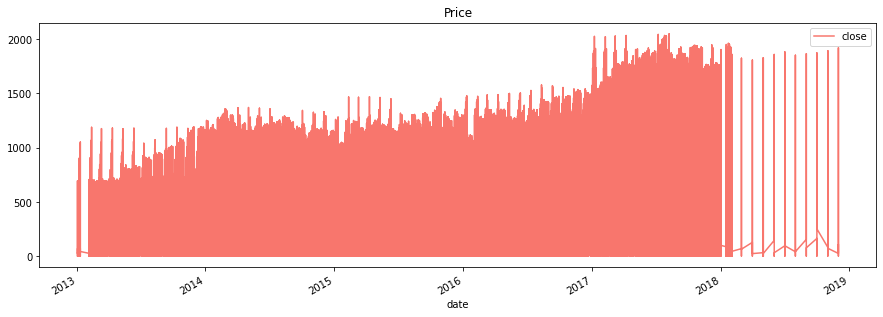

In [ ]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
df.plot(figsize=(15,5), color=color_pal[0], title='Price')
plt.show()

# EDA

We will create some time series features to see how the trends are impacted by day of week, hour, time of year, etc.

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='close')

features_and_target = pd.concat([X, y], axis=1)

In [ ]:
features_and_target.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,close
date,,,,,,,,
2013-08-02,4,3,8,2013,214,2,31,14.75
2013-11-02,5,4,11,2013,306,2,44,14.46
2013-12-02,0,4,12,2013,336,2,49,14.27
2013-02-13,2,1,2,2013,44,13,7,14.66
2013-02-14,3,1,2,2013,45,14,7,13.99


In [ ]:
features_and_target.describe()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,close
count,619040.000000,619040.000000,619040.000000,619040.000000,619040.000000,619040.000000,619040.000000,619040.000000
mean,2.410075,2.528051,6.586385,2015.125202,184.978769,15.697336,26.870514,83.043763
std,1.725672,1.112543,3.420708,1.445837,104.392060,8.778647,14.923037,97.389748
min,0.000000,1.000000,1.000000,2013.000000,2.000000,1.000000,1.000000,1.590000
25%,1.000000,2.000000,4.000000,2014.000000,95.000000,8.000000,14.000000,40.245000
50%,2.000000,3.000000,7.000000,2015.000000,186.000000,16.000000,27.000000,62.620000
75%,4.000000,4.000000,10.000000,2016.000000,275.000000,23.000000,40.000000,94.410000
max,6.000000,4.000000,12.000000,2018.000000,365.000000,31.000000,53.000000,2049.000000


We can infer from the following that highest sale has been made on Monday overall with sales upto 1023536329

In [ ]:
highest_sold=features_and_target.groupby(['dayofweek']).sum()
highest_sold[['close']]


,close
dayofweek,
0,8.561360e+06
1,9.390004e+06
2,9.369756e+06
3,9.103924e+06
4,9.281514e+06
5,2.732158e+06
6,2.968695e+06


In [ ]:
highest_sold[['close']].max()

close    9.390004e+06
dtype: float64

Plotting the Features to see trends
Sale demand has strong daily and seasonal properties.
Day of week also seems to show differences in peaks


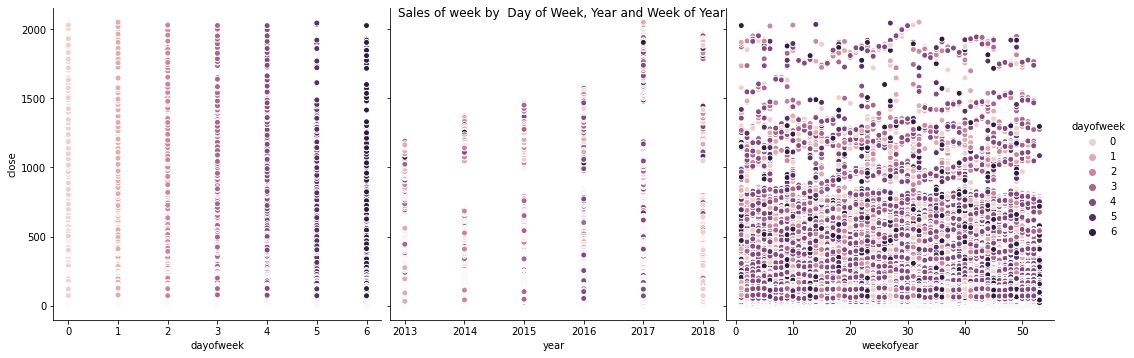

In [ ]:
sns.pairplot(features_and_target.dropna(),
             hue='dayofweek',
             x_vars=['dayofweek',
                     'year','weekofyear'],
             y_vars='close',
             height=5,
             plot_kws={'alpha':1, 'linewidth':1}
            )
plt.suptitle('Sales of week by  Day of Week, Year and Week of Year')
plt.show()

In [ ]:
#Splitting the dataset from 1966
split_date = '2017-01-21'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()


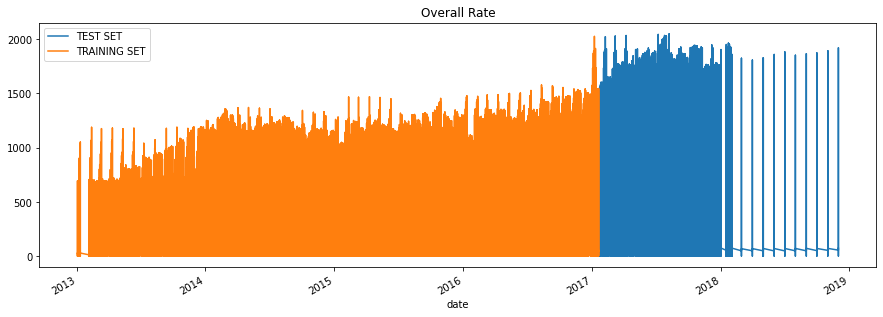

In [ ]:
# Plot train and test so you can see where we have split
df_test \
    .rename(columns={'close': 'TEST SET'}) \
    .join(df_train.rename(columns={'close': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='Overall Rate', )
plt.show()

In [ ]:
# Setup and train model and fit
model = Prophet()
model.fit(df_train.reset_index() \
              .rename(columns={'date':'ds',
                               'close':'y'}))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# Predict on training set with model
df_test_fcst = model.predict(df=df_test.reset_index() \
                                   .rename(columns={'date':'ds'}))
df_test_fcst.head(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-23,92.490374,-19.682726,207.687239,92.490374,92.490374,-1.543309,-1.543309,-1.543309,-0.311111,-0.311111,-0.311111,-1.232198,-1.232198,-1.232198,0.0,0.0,0.0,90.947065
1,2017-01-23,92.490374,-18.151695,191.399145,92.490374,92.490374,-1.543309,-1.543309,-1.543309,-0.311111,-0.311111,-0.311111,-1.232198,-1.232198,-1.232198,0.0,0.0,0.0,90.947065
2,2017-01-23,92.490374,-23.079193,201.076554,92.490374,92.490374,-1.543309,-1.543309,-1.543309,-0.311111,-0.311111,-0.311111,-1.232198,-1.232198,-1.232198,0.0,0.0,0.0,90.947065
3,2017-01-23,92.490374,-16.063818,204.746133,92.490374,92.490374,-1.543309,-1.543309,-1.543309,-0.311111,-0.311111,-0.311111,-1.232198,-1.232198,-1.232198,0.0,0.0,0.0,90.947065
4,2017-01-23,92.490374,-26.628347,201.290869,92.490374,92.490374,-1.543309,-1.543309,-1.543309,-0.311111,-0.311111,-0.311111,-1.232198,-1.232198,-1.232198,0.0,0.0,0.0,90.947065


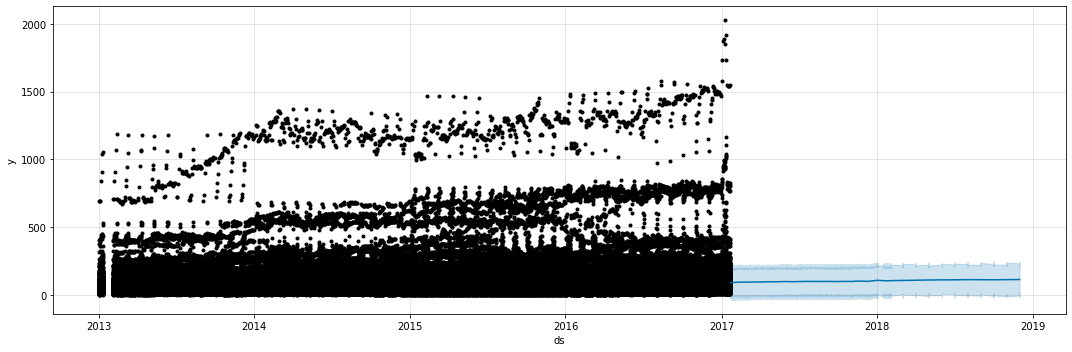

In [ ]:
# Plot the forecast for trained model
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(df_test_fcst,ax=ax
                 )
plt.show()

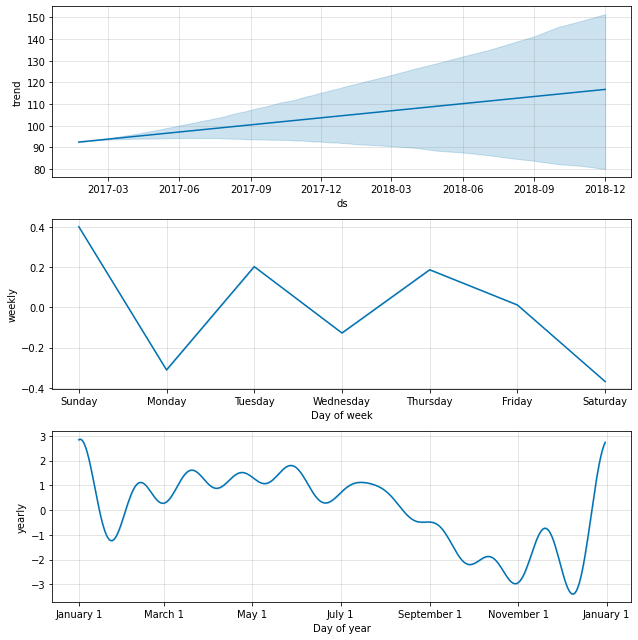

In [ ]:
# Plot the components of the model
fig = model.plot_components(df_test_fcst)

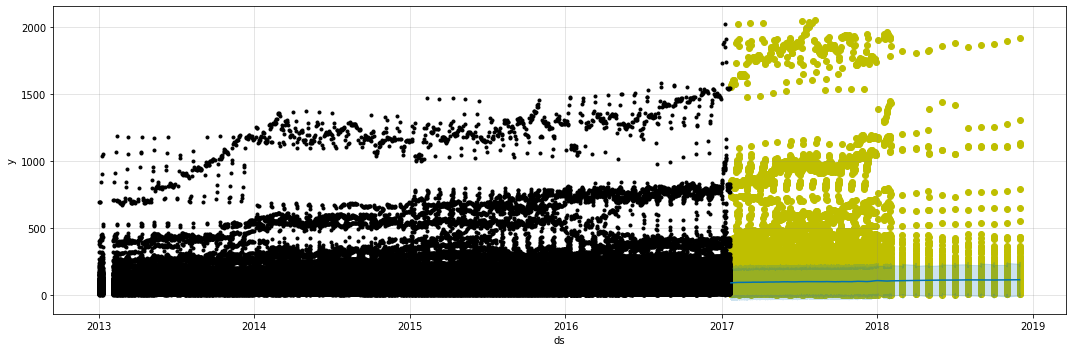

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_test.index, df_test['close'], color='y')
fig = model.plot(df_test_fcst, ax=ax)

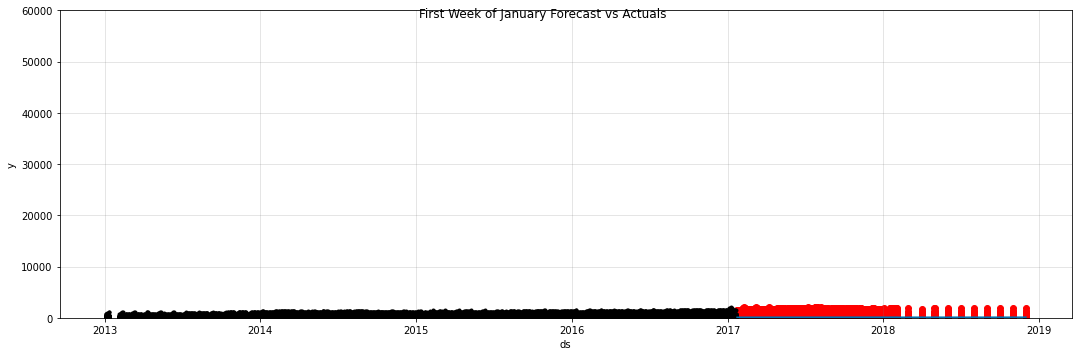

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_test.index, df_test['close'], color='r')
fig = model.plot(df_test_fcst, ax=ax)
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

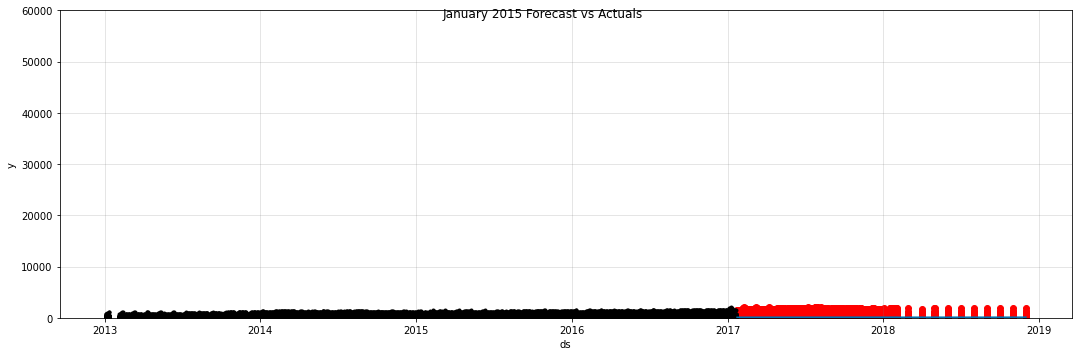

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_test.index, df_test['close'], color='r')
fig = model.plot(df_test_fcst, ax=ax)

ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

In [ ]:
from sklearn.neural_network import MLPRegressor 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_true=df_test['close'],
                   y_pred=df_test_fcst['yhat'])


15980.55069027158

In [ ]:
mean_absolute_error(y_true=df_test['close'],
                   y_pred=df_test_fcst['yhat'])

60.6894912576612

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=df_test['close'],
                   y_pred=df_test_fcst['yhat'])

101.70997263513797

Our RMSE error is 8652706.39
Our MAE error is 2556
Our MAPE error is 15.985%

In [ ]:
future = model.make_future_dataframe(periods=3)
forecast = model.predict(future)

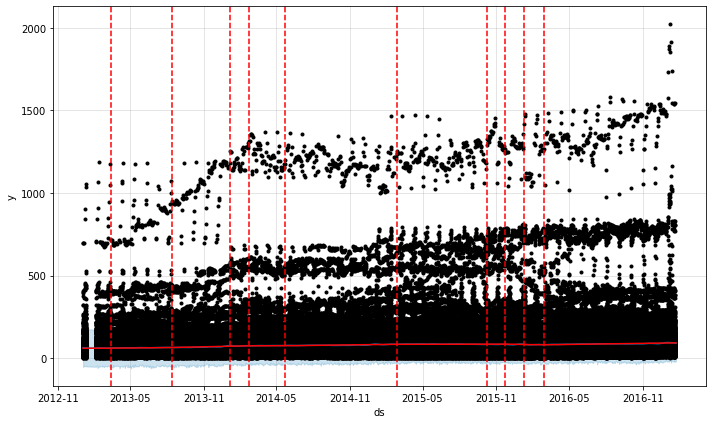

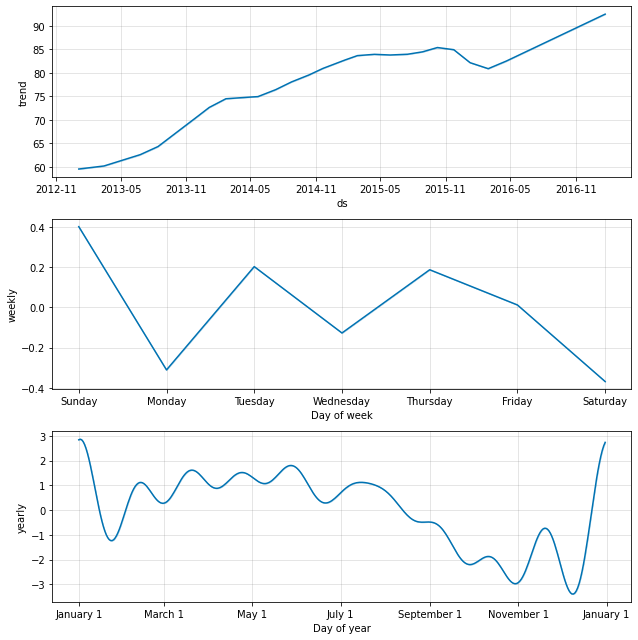

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
993,2017-01-19,92.346949,-21.586825,204.615632,92.346949,92.346949,-0.659730,-0.659730,-0.659730,0.188116,0.188116,0.188116,-0.847846,-0.847846,-0.847846,0.0,0.0,0.0,91.687219
994,2017-01-20,92.382805,-19.701057,211.905214,92.382805,92.382805,-0.986036,-0.986036,-0.986036,0.012586,0.012586,0.012586,-0.998622,-0.998622,-0.998622,0.0,0.0,0.0,91.396769
995,2017-01-21,92.418662,-21.169389,194.166336,92.418662,92.418662,-1.482645,-1.482645,-1.482645,-0.369085,-0.369085,-0.369085,-1.113560,-1.113560,-1.113560,0.0,0.0,0.0,90.936016
996,2017-01-22,92.454518,-22.101477,195.519169,92.454518,92.454518,-0.788654,-0.788654,-0.788654,0.402849,0.402849,0.402849,-1.191503,-1.191503,-1.191503,0.0,0.0,0.0,91.665864
997,2017-01-23,92.490374,-13.794826,207.698306,92.490374,92.490374,-1.543309,-1.543309,-1.543309,-0.311111,-0.311111,-0.311111,-1.232198,-1.232198,-1.232198,0.0,0.0,0.0,90.947065


In [ ]:
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)
from matplotlib import pyplot as plt
plt.show()
fig2 = model.plot_components(forecast)
plt.show()
forecast.tail()

In [ ]:
type(forecast)

pandas.core.frame.DataFrame